# Introdução e contexto

## Parâmetros utilizados

* Todo vendedor tem um salário base de 1500

* 5% de comissao pelo total das suas vendas no mes

* Adicional de 50% em cima da comissao se a meta for atingida

* 100 reais adicionais para 10 vendas de produtos de margem alta de vendas, para cada categoria (não acumulativo na mesma categoria)

## Variáveis analisadas

**Preço das Vendas (preco):**

Por que: Base para calcular a comissão dos vendedores.

Uso: Determina a comissão base e analisa a distribuição de vendas.

**Meta de Vendas (sales_target):**

Por que: Influencia o adicional de 50% na comissão.

Uso: Avalia o atingimento de metas e seu impacto na comissão.

**Quantidade de Produtos Vendidos de Margem Alta (quantidade):**

Por que: Determina bônus adicionais.

Uso: Calcula o bônus de R$100 por cada 10 produtos de margem alta vendidos.

**Comissão Final (comissao_final):**

Por que: Reflete o desempenho ajustado pela meta.

Uso: Analisa a compensação final dos vendedores.

**Rentabilidade Total (rentabilidade):**

Por que: Resumo da compensação total do vendedor.

Uso: Avalia o sucesso financeiro total do vendedor, integrando salário, comissão, e bônus

## Estruturação de dados

**Categorias de Dados:**

* Temporais: Colunas data e month permitem análises temporais essenciais para projeções de vendas.

* Financeiras: Colunas preco, comissao_final, e rentabilidade capturam a performance financeira dos vendedores.

* Desempenho e Incentivos: sales_target e quantidade foram estruturadas para avaliar o cumprimento de metas e calcular bônus.

**Justificativa:**

A estrutura facilita análises detalhadas e específicas, garantindo que cada aspecto do desempenho do vendedor seja avaliado com clareza. Isso suporta decisões estratégicas na gestão de vendas e remuneração, maximizando a eficiência e a qualidade dos insights.

# Execução em código


## Importação de bibliotecas e Datasets


In [2]:
# Carregando as bibliotecas necessárias
library(ggplot2)
library(dplyr)

# Carregando os arquivos CSV
vendas_df <- read.csv("/content/transaction_fact_v3_2024.csv")
metas_df <- read.csv("/content/targets_salesperson_final_v3.csv")

# Exibindo as primeiras linhas para verificar a carga dos dados
head(vendas_df)
head(metas_df)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




,data,cod_vendedor,cod_loja,cod_transacao,quantidade,cod_prod,preco
,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>
1,2024-05-29,917,SP Capital Centro_48,000484fc7c,1,917845373827,88.60280
2,2024-05-31,58,SP Capital Centro_99,0012fb5659,2,705516174930,123.62559
3,2024-05-31,58,SP Capital Centro_99,0012fb5659,1,715775125765,66.96472
4,2024-05-31,287,SP Interior_32,001af83ace,1,336847961663,66.96472
5,2024-05-30,371,SP Capital Centro_11,0026881cb2,2,426037160751,144.23329
6,2024-05-29,534,RJ_57,003449351c,4,814394039436,440.96355


,id_employee,sales_target,month
,<int>,<int>,<chr>
1,924,86021,10/2014
2,924,86398,11/2014
3,924,93739,12/2014
4,924,88751,01/2015
5,924,83398,02/2015
6,924,80121,03/2015


##Conversões e Ajustes dos dados

In [3]:
# Converter colunas de datas para formato Date
vendas_df$data <- as.Date(vendas_df$data)
metas_df$month <- as.Date(paste0(metas_df$month,"-01"), format ="%Y-%m-%d")

# Verificar se as conversões foram bem-sucedidas
str(vendas_df)
str(metas_df)

# Converter colunas numéricas para tipos mais eficientes
vendas_df <- vendas_df %>%
  mutate(across(where(is.numeric),as.numeric))%>%
  mutate(across(where(is.character), as.factor))

metas_df <- metas_df %>%
  mutate(across(where(is.numeric),as.numeric))%>%
  mutate(across(where(is.character), as.factor))

'data.frame':	290525 obs. of  7 variables:
 $ data         : Date, format: "2024-05-29" "2024-05-31" ...
 $ cod_vendedor : int  917 58 58 287 371 534 634 634 108 897 ...
 $ cod_loja     : chr  "SP Capital Centro_48" "SP Capital Centro_99" "SP Capital Centro_99" "SP Interior_32" ...
 $ cod_transacao: chr  "000484fc7c" "0012fb5659" "0012fb5659" "001af83ace" ...
 $ quantidade   : int  1 2 1 1 2 4 4 1 2 2 ...
 $ cod_prod     : num  9.18e+11 7.06e+11 7.16e+11 3.37e+11 4.26e+11 ...
 $ preco        : num  88.6 123.6 67 67 144.2 ...
'data.frame':	97142 obs. of  3 variables:
 $ id_employee : int  924 924 924 924 924 924 924 924 924 924 ...
 $ sales_target: int  86021 86398 93739 88751 83398 80121 86492 87217 83984 83374 ...
 $ month       : Date, format: NA NA ...


In [4]:
# Recurso de otimização do dataset
# Amostragem de 10% dos dados, ajustável conforme necessário
set.seed(123)# Para reprodutibilidade
vendas_df <- vendas_df %>% sample_frac(0.1)

## Cálculos baseado nos parâmetros definidos

In [5]:
# Cálculo da comissão base (5% do total de vendas)
vendas_df <- vendas_df %>%
  mutate(comissao_base = preco *0.05)

# Unir os DataFrames pelas chaves corretas (cod_vendedor e id_employee)
vendas_df <- vendas_df %>%
  left_join(metas_df, by =c("cod_vendedor"="id_employee"))

# Verificar se a meta foi atingida
vendas_df <- vendas_df %>%
  mutate(meta_atingida = preco >= sales_target)

# Cálculo da comissão final
vendas_df <- vendas_df %>%
  mutate(comissao_final = ifelse(meta_atingida, comissao_base *1.5, comissao_base))

# Cálculo do bônus de R$100 para cada 10 vendas de produtos de margem alta
vendas_df <- vendas_df %>%
  mutate(bonus_margem_alta =(quantidade %/%10)*100)

# Cálculo da rentabilidade total do vendedor
vendas_df <- vendas_df %>%
  mutate(rentabilidade =1500+ comissao_final + bonus_margem_alta)

# Verificação dos cálculos
head(vendas_df %>% select(cod_vendedor, comissao_base, comissao_final, bonus_margem_alta, rentabilidade))

Warning message in left_join(., metas_df, by = c(cod_vendedor = "id_employee")):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 26068 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


,cod_vendedor,comissao_base,comissao_final,bonus_margem_alta,rentabilidade
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,648,3.084045,3.084045,0,1503.084
2,648,3.084045,3.084045,0,1503.084
3,648,3.084045,3.084045,0,1503.084
4,648,3.084045,3.084045,0,1503.084
5,648,3.084045,3.084045,0,1503.084
6,648,3.084045,3.084045,0,1503.084


## Representação visual das analises contituidas

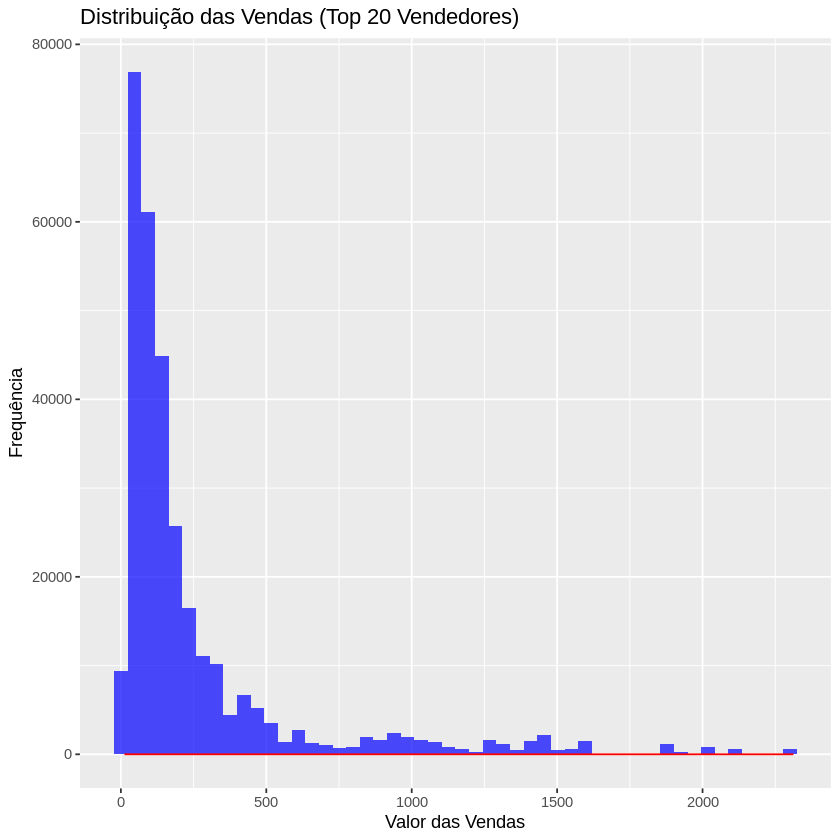

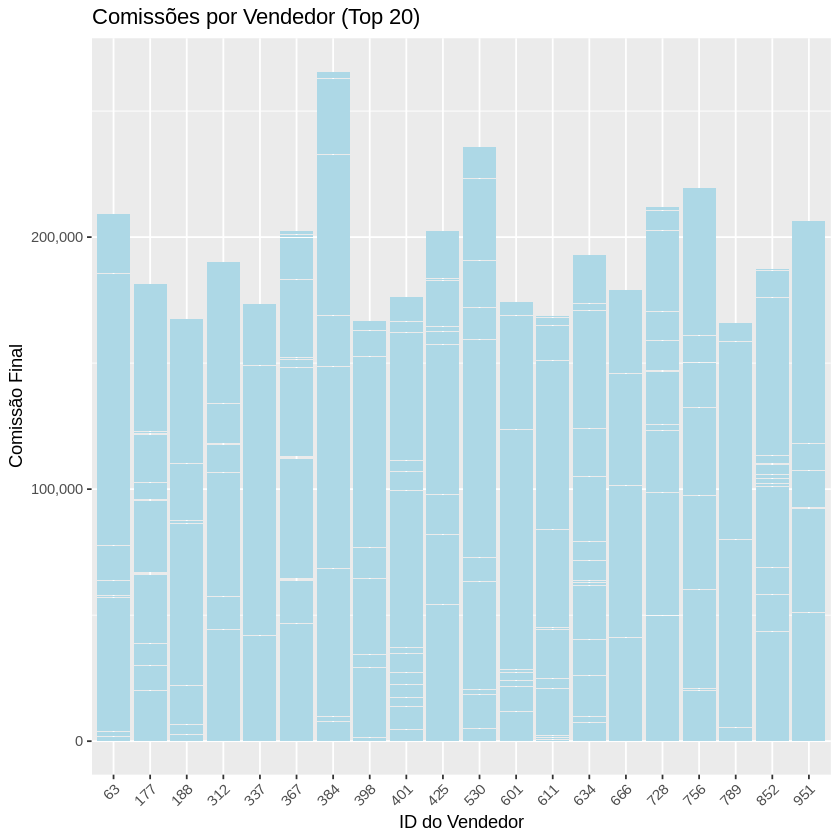

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1162401,62.1,1828641,97.7,1828641,97.7
Vcells,71962595,549.1,128734031,982.2,128672004,981.7


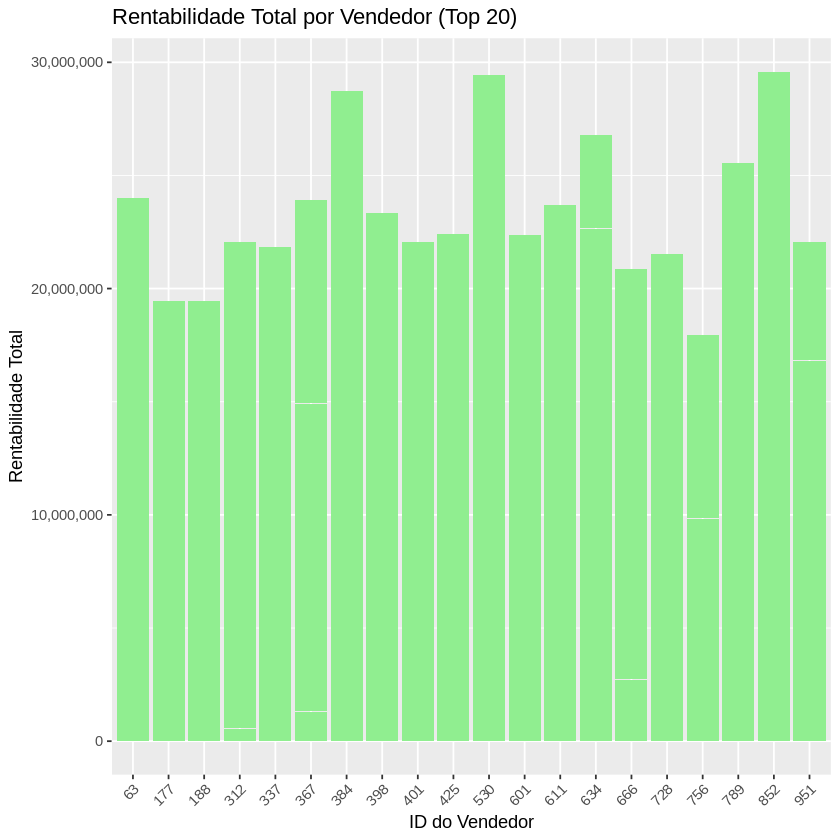

In [6]:
library(ggplot2)
library(scales)

# Biblioteca necessária para formatação# Identificar os top 20 vendedores com base no total de vendas
top_vendedores <- vendas_df %>%
  group_by(cod_vendedor)%>%
  summarise(total_vendas =sum(preco))%>%
  arrange(desc(total_vendas))%>%
  head(20)%>%
  pull(cod_vendedor)

# Filtrando os dados para os top 20 vendedores apenas
vendas_df_filtered <- vendas_df %>%
  filter(cod_vendedor %in% top_vendedores)

# Distribuição das Vendas (usando a amostra)
ggplot(vendas_df_filtered, aes(x = preco))+
  geom_histogram(bins =50, fill ="blue", alpha =0.7)+
  geom_density(color ="red", adjust =1)+
  labs(title ="Distribuição das Vendas (Top 20 Vendedores)", x ="Valor das Vendas", y ="Frequência")

# Comissões por Vendedor (apenas para os top 20 vendedores)
ggplot(vendas_df_filtered, aes(x = factor(cod_vendedor), y = comissao_final))+
  geom_bar(stat ="identity", fill ="lightblue")+
  labs(title ="Comissões por Vendedor (Top 20)", x ="ID do Vendedor", y ="Comissão Final")+
  scale_y_continuous(labels = comma)+
  theme(axis.text.x = element_text(angle =45, hjust =1))

# Rentabilidade Total por Vendedor (apenas para os top 20 vendedores)
ggplot(vendas_df_filtered, aes(x = factor(cod_vendedor), y = rentabilidade))+
  geom_bar(stat ="identity", fill ="lightgreen")+
  labs(title ="Rentabilidade Total por Vendedor (Top 20)", x ="ID do Vendedor", y ="Rentabilidade Total")+
  scale_y_continuous(labels = comma)+
  theme(axis.text.x = element_text(angle =45, hjust =1))

# Remover objetos intermediários para liberar memória
rm(vendas_df_filtered, top_vendedores)
gc()

## Insights derivados das analises prévias

In [7]:

# 1. Análise de Vendedores com Maior Rentabilidade# Identificar os top 5 vendedores em termos de rentabilidade total
top_vendedores_rentabilidade <- vendas_df %>%
  group_by(cod_vendedor)%>%
  summarise(total_rentabilidade =sum(rentabilidade))%>%
  arrange(desc(total_rentabilidade))%>%
  head(5)

cat("Top 5 vendedores em termos de rentabilidade total:\n")
print(top_vendedores_rentabilidade)

# 2. Percentual de Vendedores que Atingiram a Meta# Calcular o percentual de vendedores que atingiram a meta em relação ao total
percent_vendedores_meta <- vendas_df %>%
  group_by(cod_vendedor)%>%
  summarise(meta_atingida =any(meta_atingida))%>%
  summarise(percent_meta = mean(meta_atingida)*100)

cat("Percentual de vendedores que atingiram a meta:", percent_vendedores_meta$percent_meta,"%\n")

# 3. Impacto da Meta no Total de Comissões# Comparar a média de comissão final entre vendedores que bateram a meta e os que não bateram
media_comissao_por_meta <- vendas_df %>%
  group_by(meta_atingida)%>%
  summarise(media_comissao_final = mean(comissao_final))

cat("Média de comissão final para vendedores que bateram a meta:", media_comissao_por_meta$media_comissao_final[2],"\n")
cat("Média de comissão final para vendedores que não bateram a meta:", media_comissao_por_meta$media_comissao_final[1],"\n")

# 4. Produtos de Margem Alta - Desempenho# Verificar quais vendedores venderam mais produtos de margem alta e como isso impactou a rentabilidade
produtos_margem_alta_desempenho <- vendas_df %>%
  group_by(cod_vendedor)%>%
  summarise(total_produtos_margem_alta =sum(quantidade),
            total_rentabilidade =sum(rentabilidade))%>%
  arrange(desc(total_produtos_margem_alta))

cat("Desempenho dos vendedores em termos de produtos de margem alta vendidos:\n")
print(produtos_margem_alta_desempenho)

# 5. Comparação de Rentabilidade entre Lojas# Comparar a rentabilidade média dos vendedores entre diferentes lojas
rentabilidade_por_loja <- vendas_df %>%
  group_by(cod_loja)%>%
  summarise(media_rentabilidade = mean(rentabilidade))%>%
  arrange(desc(media_rentabilidade))

cat("Comparação de rentabilidade média entre lojas:\n")
print(rentabilidade_por_loja)

Top 5 vendedores em termos de rentabilidade total:
# A tibble: 5 × 2
  cod_vendedor total_rentabilidade
         <dbl>               <dbl>
1          852           29582326.
2          530           29428788.
3          384           28735599.
4          634           26790781.
5          528           26269973.
Percentual de vendedores que atingiram a meta: 0 %
Média de comissão final para vendedores que bateram a meta: NA 
Média de comissão final para vendedores que não bateram a meta: 9.944092 
Desempenho dos vendedores em termos de produtos de margem alta vendidos:
# A tibble: 609 × 3
   cod_vendedor total_produtos_margem_alta total_rentabilidade
          <dbl>                      <dbl>               <dbl>
 1          384                      41756           28735599.
 2          530                      40765           29428788.
 3          634                      39754           26790781.
 4          398                      39204           23332786.
 5          957           